In [22]:
# import libraries
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import pyModeS as pms
import gc

%matplotlib inline

In [2]:
sdr = RtlSdr()
fs = 2000000;
sdr.set_sample_rate(fs)    # sampling rate
sdr.set_center_freq(434.03e6)   # 1090MhZ center frequency
sdr.set_gain(0) 
N_Samples = 2048000 # approx 1 sec

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2000000.052982 Hz


In [36]:
THRESHOLD = 0.015
PREAMBLE_SEQUENCE = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

In [37]:
def convert_to_binary(sequence):
    return [int(val > THRESHOLD) for val in sequence]

In [38]:
def downsample(sample, orig_freq, new_freq):
    assert 0 < new_freq < orig_freq, "New freq must be less than original frequency and greater than zero"
    assert orig_freq / new_freq == orig_freq // new_freq, "Original frequency must be a multiple of the new frequency"
    return sample[::orig_freq // new_freq]

In [39]:
def detect_data_from_preamble(sample):
    detected_indices = []
    for i in range(0, len(sample) - 16):
        # Compute the score
        score = (sample[i:i+16] == PREAMBLE_SEQUENCE)
        # If score == 1, return i + 16
        if score == True:
            detected_indices.append(i)
    return detected_indices

In [66]:
def decode(pulse_pattern):
    result = []
    assert len(pulse_pattern) == 16
    for i in range(0, 16, 2):
        if pulse_pattern[0] == 1 and pulse_pattern[1] == 0:
            result.append(1)
        elif pulse_pattern[1] == 1 and pulse_pattern[0] == 0:
            result.append(0)
        else:
            result.append(0)
    res = 0
    for i in range(8):
        res += 2**(8 - i) * result[i]
    return res

def convert_to_char(ascii_index):
    return chr(ascii_index)
    

In [67]:
N_Samples

2048000

In [68]:
y = abs(sdr.read_samples(N_Samples))   # get samples
y = downsample(y, fs, 200)
data = convert_to_binary(y)

Text(0.5, 0, 'samples')

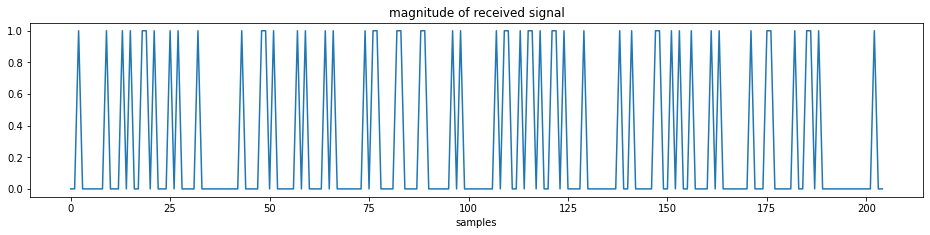

In [69]:
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
p = plot( (data))
title('magnitude of received signal')
xlabel('samples')

In [70]:
data

[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

(array([131.,   0.,   0.,   0.,   0.,   0.,   0.,  19.,   0.,   0.,   0.,
          0.,  18.,   0.,   0.,   0.,  28.,   0.,   0.,   9.]),
 array([0.00554594, 0.00641196, 0.00727799, 0.00814402, 0.00901004,
        0.00987607, 0.0107421 , 0.01160813, 0.01247415, 0.01334018,
        0.01420621, 0.01507223, 0.01593826, 0.01680429, 0.01767032,
        0.01853634, 0.01940237, 0.0202684 , 0.02113442, 0.02200045,
        0.02286648]),
 <BarContainer object of 20 artists>)

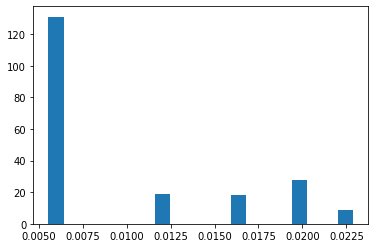

In [71]:
plt.hist(y, bins = 20)

In [72]:
detected = detect_data_from_preamble(data)
print(detected)
for pair in zip(detected, detected[1:]):
    print(pair[1] - pair[0])
    
for item in detected:
    print(convert_to_char(decode(data[item+16:item+32])))

[57]
 


In [73]:
len(data

SyntaxError: unexpected EOF while parsing (704503705.py, line 1)

In [74]:
len(data)

205

Text(0.5, 0, 'samples')

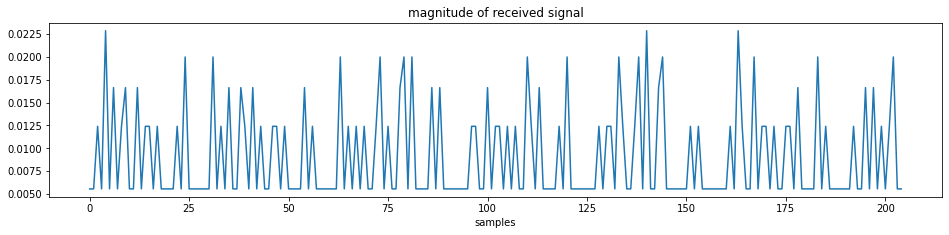

In [62]:
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
p = plot(y[:10000])
title('magnitude of received signal')
xlabel('samples')

In [63]:
%xdel -n fig
%xdel -n p
gc.collect(2)

3557

In [64]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:           15Gi       3.1Gi       8.5Gi       480Mi       4.0Gi        11Gi
Swap:         975Mi       133Mi       842Mi
